# Atmospheric Model Assumptions
1. The atmospheric air density decreases exponentially with increasing altitude 
2. The drag force is proportional to the square of velocity (turbulent drag)
3. The gravitational acceleration decreases with altitude (although mostly negligible)

### Equation of motion:
The atmospheric drag and gravitational forces contribute to the equation of motion:
\begin{align}
m\ddot{z} &= F_G + F_D \\
m\ddot{z} &= - \frac{GMm}{(R + z)^2} + \frac{1}{2}C_D A \rho_0  \exp \left( -\frac{z}{H_O} \right) \; \dot{z}^2
\end{align}
where $G$ is Newton's gravitational constant, $M$ is the mass of the Earth, $R$ is the radius of the Earth (spherical assumption), $\rho_0$ is the air density at STP, $A$ is the skydiver's cross sectional area, $C_D$ is the drag coefficient, $H_0$ is the scale height of the atmosphere, and $m$ is the mass of the skydiver and z is the altitude of the skydiver. The dot notation indicates a time derivative.  

For the skydiver, we assume that they are dropped from an initial height $h_0$. This implies that our initial conditions are:
\begin{align}
z(0) &= h_0 \\
\dot{z}(0) &= 0
\end{align}
Let $g=\frac{GM}{R^2}$ where $g$ is the standard gravitational acceleration so that
\begin{align}
\frac{GMm}{(R + z)^2} &= \frac{GMm}{R^2 \left(1 + \frac{z}{R} \right)^2} \\
&= \frac{GM}{R^2}  \frac{m}{\left(1 + \frac{z}{R} \right)^2} \\ 
&= \frac{mg}{\left(1 + \frac{z}{R} \right)^2} 
\end{align}

For $z << R$, we can use the binomial approximation:
\begin{align}
\frac{mg}{\left(1 + \frac{z}{R} \right)^2} &\approx mg\left(1 - \frac{2z}{R} \right)
\end{align}
With this approximation, we have 
\begin{align}
m\ddot{z} &= -mg\left(1 - \frac{2z}{R} \right)  + \frac{1}{2}C_D A \rho_0  \exp \left( -\frac{z}{H_O} \right) \; \dot{z}^2.
\end{align}
Dividing by $m$ we have the equation 
\begin{align}
\ddot{z} &= -g\left(1 - \frac{2z}{R} \right)  + \frac{1}{2m}C_D A \rho_0  \exp \left( -\frac{z}{H_O} \right) \; \dot{z}^2
\end{align}
which is a second order non-linear differential equation. 

Letting $\dot{z}$ = w, we can form a system of ODEs that we can numerically integrate.
\begin{align}
\dot{z} &= w\\
\dot{w} &= -g\left(1 - \frac{2z}{R} \right)  +  a \exp \left( -b z \right) \; w^2
\end{align} 
where $a = \frac{1}{2m}C_D A \rho_0$ and $b = \frac{1}{H_0}$. These parameters will be fit to experimental data using a nonlinear least squares method. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from scipy.integrate import odeint
%matplotlib inline

In [2]:
# Constants
DRAG_COEFFICIENT           = 0.75
CROSS_SECTIONAL_AREA       = 0.5             # meters^2
DENSITY_OF_AIR             = 1.293           # kilogram/meter^3
SCALE_HEIGHT               = 8.5 * 1000      # meters
MASS                       = 20              # kilograms
GRAVITATIONAL_ACCELERATION = 9.80665         # meters/sec^2
RADIUS_OF_EARTH            = 6378.137 * 1000 # meters

# Unit conversions 
SEC_TO_MINS = 1/60
HR_TO_SEC   = 3600
M_TO_KM     = 1/1000
KPH_TO_MPS  = 1000/3600 

In [3]:
# Model parameters - intitial guess
a = (DRAG_COEFFICIENT * CROSS_SECTIONAL_AREA * DENSITY_OF_AIR) / (2 * MASS)
b = 1 / SCALE_HEIGHT

In [4]:
def model1(y, t, a, b):
    ''' 
    Model equations 
        z' = w 
        w' = -g(1 - z / R) + exp(-beta * z) * w^2
    '''  
    g = GRAVITATIONAL_ACCELERATION
    R = RADIUS_OF_EARTH
    
    z, w = y
    dydt = np.array([w, -g * (1 - 2 * z/R) + a * np.exp(-b * z) * w**2])
    return dydt

# Comparison of Atmospheric Model to Experimental Data

In [5]:
# Load in RedBullStratos data
data = (pd.read_csv('RedBullStratosData180.csv', 
                   usecols=['time', 'altitude_m', 'airspeed_kph'])
        .dropna()
        .sort_values(by='time')
        .query('time < 251.40') #before parachute is deployed
)

In [6]:
# Initial conditons based on data
INITIAL_HEIGHT   = data.altitude_m.values[0]
INITIAL_VELOCITY = data.airspeed_kph.values[0] * KPH_TO_MPS

y0 = np.array([INITIAL_HEIGHT, INITIAL_VELOCITY])

In [7]:
# Fitting parameters of the model 
def fit_model_parameters(initial_conditions, experimental_data, initial_guess): 
    def func(t, alpha, beta):
        return odeint(model1, initial_conditions, t, args=(alpha, beta))[:,0]
    
    params, cov = curve_fit(func, experimental_data.time, experimental_data.altitude_m, p0=initial_guess)
    return params

a_fit, b_fit = fit_model_parameters(y0, data, [a, b])

In [8]:
# Fitted model parameters
a_fit, b_fit

(0.00891122298952309, 0.00017426703547708097)

In [9]:
# Solution using newly fit parameters 
time = np.linspace(min(data.time.values),max(data.time.values), 1_000)
sol  = odeint(model1, y0, time, args=(a_fit, b_fit))

In [10]:
# Convert units
# model
time_mins    = time * SEC_TO_MINS
altitude_km  = sol[:, 0] * M_TO_KM
airspeed_kph = sol[:, 1] * M_TO_KM * HR_TO_SEC

# data
data_time_mins   = data.time * SEC_TO_MINS
data_altitude_km = data.altitude_m * M_TO_KM

## Plotting results

Text(0, 0.5, 'Altitude [km]')

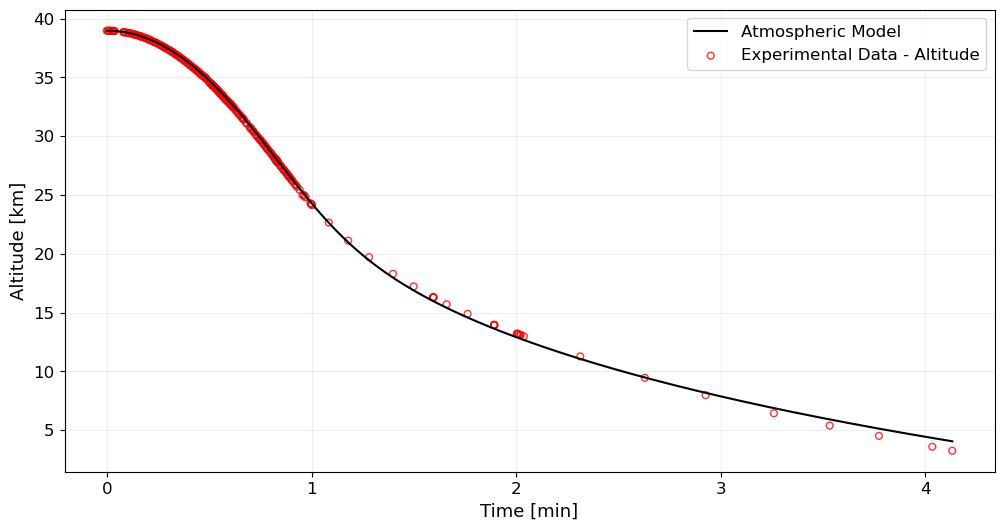

In [11]:
# Plot altitude results
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time_mins, altitude_km, color='black')
ax.scatter(data_time_mins, data_altitude_km, s=24, color='red', alpha=0.8, facecolors='none', edgecolors='red')

ax.grid(True, alpha=0.2)
ax.legend(['Atmospheric Model', 'Experimental Data - Altitude'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('Time [min]', fontsize=13)
ax.set_ylabel('Altitude [km]', fontsize=13)

(0.0, 1600.0)

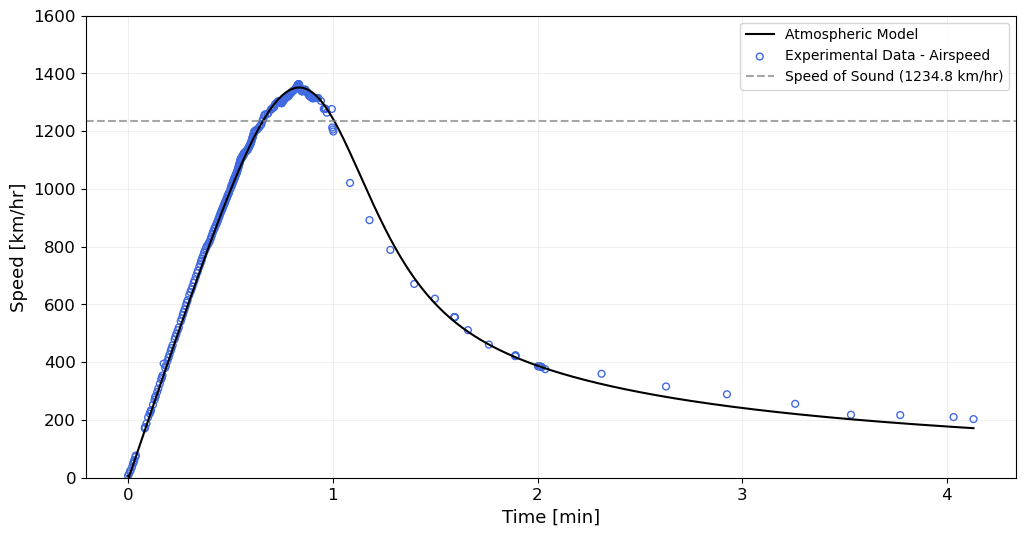

In [12]:
# Plot velocity results
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time_mins, np.abs(airspeed_kph), color='black')
ax.scatter(data_time_mins, data.airspeed_kph, s=24, facecolors='none', edgecolors='royalblue')

ax.axhline(1234.8, color='grey', linestyle='--', alpha=0.7)
ax.grid(True, alpha=0.2)
ax.legend(['Atmospheric Model', 'Experimental Data - Airspeed', 'Speed of Sound (1234.8 km/hr)'], fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('Time [min]', fontsize=13)
ax.set_ylabel('Speed [km/hr]', fontsize=13)
ax.set_ylim([0, 1600])

## Conclusion

Accounting for changes in atmospheric density is necessary when analyzing the dynamics of falling bodys from heights that greatly exceed the atmospheric scale height. The model constructed here matches well to the Red Bull Stratos jump experimental data though a better fitting of model parameters could be made provided more data during descent.